It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antoniotrapote/intro_deep_learning/blob/main/notebooks/Fundamentals/01_NN_Fundamentals.ipynb)
[![View on GitHub](https://img.shields.io/badge/View_on-GitHub-black?logo=github)](https://github.com/antoniotrapote/intro_deep_learning/blob/main/notebooks/Fundamentals/01_NN_Fundamentals.ipynb)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

In [ ]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [ ]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

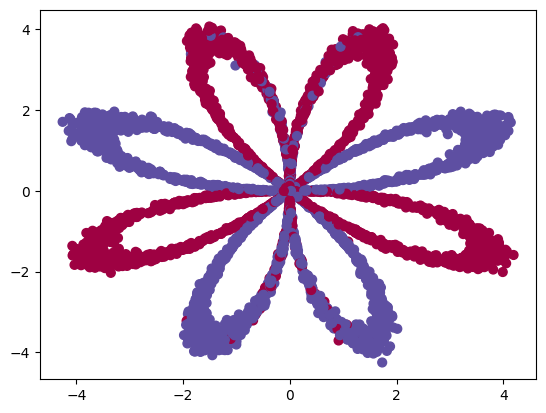

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split( X, y, test_size=0.2 )

In [ ]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [ ]:
## X first example
X[0,:]

array([-0.83185855,  1.02861762])

In [ ]:
## Y firsts examples
y[:8]

array([0, 0, 0, 1, 1, 0, 1, 0], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

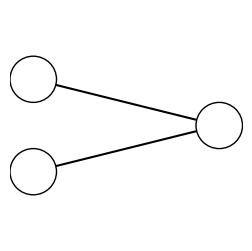

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 1])

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(2,)))  # Capa de entrada explícita
model.add(keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

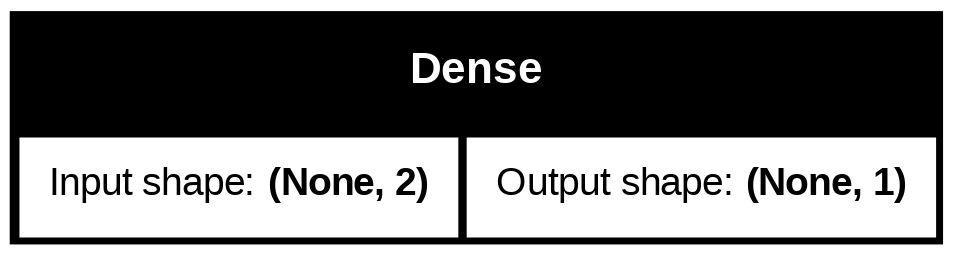

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [ ]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5387 - loss: 0.7761 - val_accuracy: 0.5437 - val_loss: 0.7311
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5276 - loss: 0.7414 - val_accuracy: 0.5375 - val_loss: 0.7027
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5148 - loss: 0.7147 - val_accuracy: 0.5200 - val_loss: 0.6818
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5019 - loss: 0.6948 - val_accuracy: 0.5125 - val_loss: 0.6674
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4894 - loss: 0.6811 - val_accuracy: 0.4975 - val_loss: 0.6584
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4765 - loss: 0.6723 - val_accuracy: 0.4975 - val_loss: 0.6533
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4713 - loss: 0.6672 - val_accuracy: 0.4888 - val_loss: 0.6509
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4695 - loss: 0.6644 - val_accuracy: 0

#### Making predictions

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.65883868932724
Test Accuracy: 0.46799999475479126


In [ ]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(array([[0.6182387],
        [0.4517014],
        [0.5452522]], dtype=float32),
 array([0, 1, 0], dtype=uint8))

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


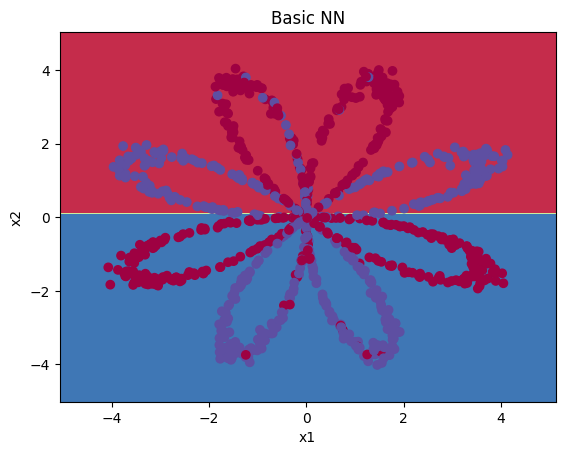

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

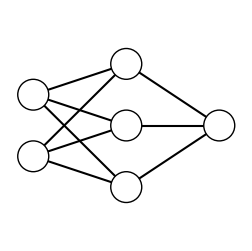

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [ ]:
model = keras.Sequential()
# Explicit input layer
model.add(keras.Input(shape=(2,)))

# Hidden layer with 3 neurons and sigmoid activation
model.add(keras.layers.Dense(3, activation='sigmoid', name='hiden_layer'))

# Output layer
model.add(keras.layers.Dense(1, activation='sigmoid', name='output_layer'))

# Model summary
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hiden_layer (Dense)             │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

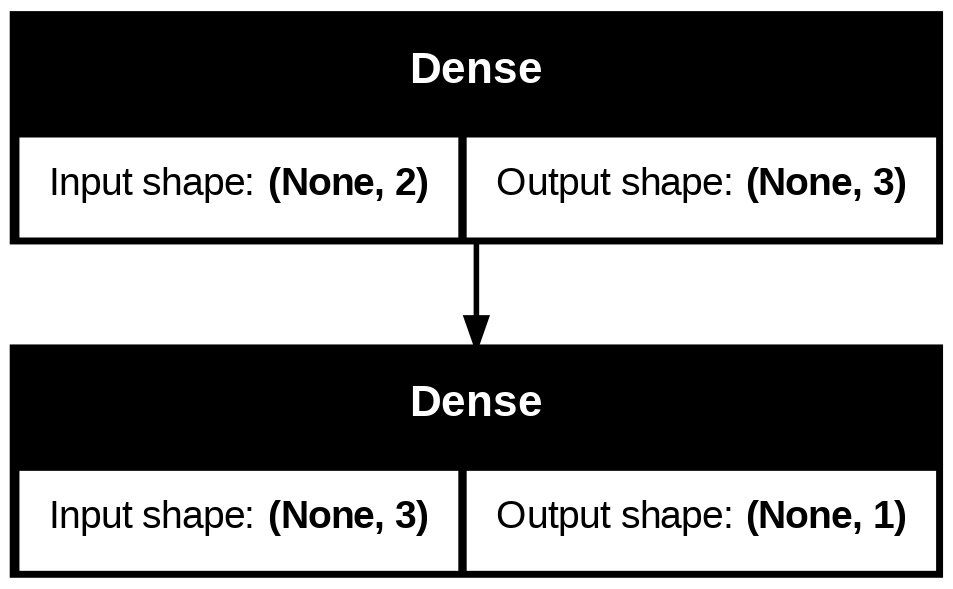

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# Compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32, verbose=0)

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5671406388282776
Test Accuracy: 0.8100000023841858


1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


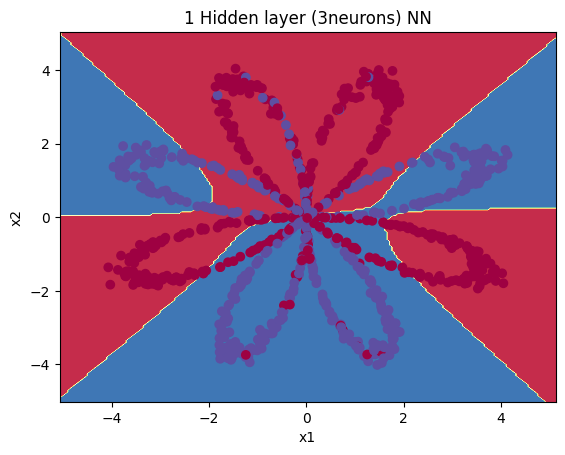

In [ ]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer (3neurons) NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(2,)))  # Explicit input layer
model.add(keras.layers.Dense(3, activation='linear')) # Hiden layer with 3 neurons
model.add(keras.layers.Dense(1, activation='sigmoid')) # Output layer

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32, verbose=0)

Test Loss: 0.6591680645942688
Test Accuracy: 0.4699999988079071
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


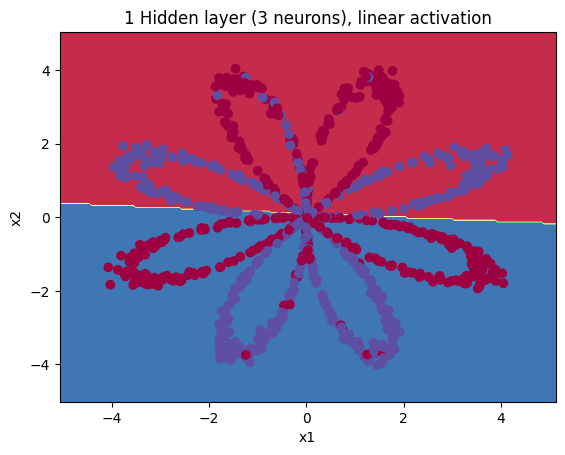

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer (3 neurons), linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

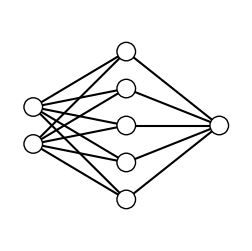

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(2,)))
model.add(layers.Dense(5, activation='sigmoid')) # Hidden layer with 5 neurons
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32, verbose=0)

Test Loss: 0.5554452538490295
Test Accuracy: 0.6190000176429749
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


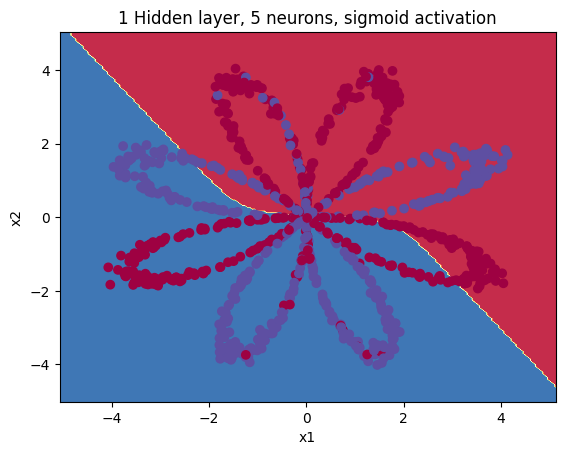

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer, 5 neurons, sigmoid activation");

### **Question 3**:
####  What happens if we add one more hidden layer ?

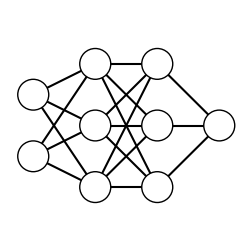

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(2,)))
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid')) # First hidden layer (neurons = 3)
model.add(layers.Dense(3, activation='relu')) # Second hidden layer (neurons = 3, activation=relu)
model.add(layers.Dense(1, activation='sigmoid')) # Output layer

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32, verbose=0)

Test Loss: 0.36605504155158997
Test Accuracy: 0.8840000033378601
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


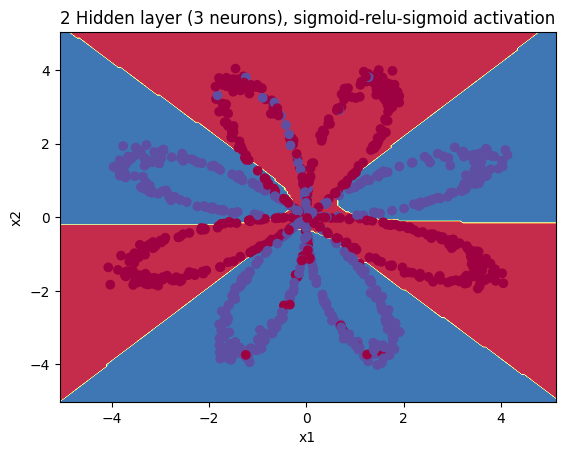

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("2 Hidden layer (3 neurons), sigmoid-relu-sigmoid activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

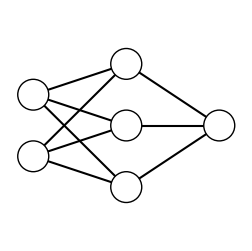

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [ ]:
model = keras.Sequential()
model.add(Input(shape=(2,)))
model.add(layers.Dense(3, activation='tanh')) # hidden layer activation = tanh
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [ ]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32, verbose=0)

Test Loss: 0.5488379001617432
Test Accuracy: 0.6349999904632568
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


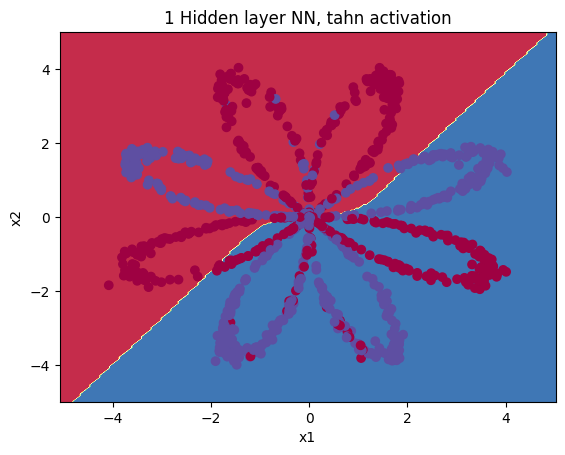

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, tahn activation");

## Practice I

Repeat the process with a different dataset.

In [ ]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

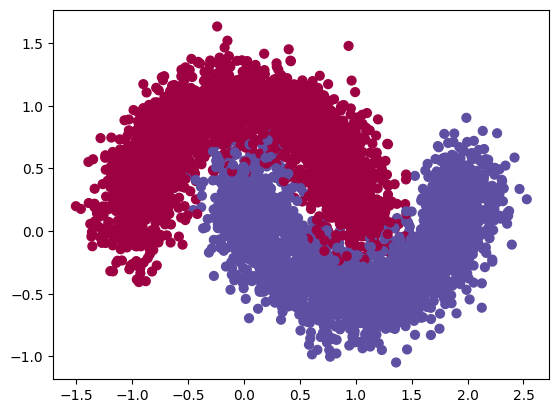

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(f'X shape:{X.shape}, y shape:{y.shape}')
print(f'X_train shape:{X_train.shape}, y_train shape:{y_train.shape}')
print(f'X_test shape:{X_test.shape}, y_test shape:{y_test.shape}')

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

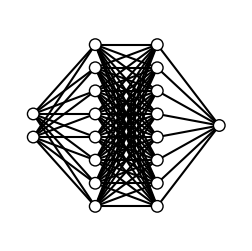

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 8, 8, 1])

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

In [ ]:
# Compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32) # ! epochs=50

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5369 - loss: 0.6791 - val_accuracy: 0.7960 - val_loss: 0.5975
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7949 - loss: 0.5727 - val_accuracy: 0.8307 - val_loss: 0.4857
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8352 - loss: 0.4524 - val_accuracy: 0.8507 - val_loss: 0.3814
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8598 - loss: 0.3512 - val_accuracy: 0.8547 - val_loss: 0.3363
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8684 - loss: 0.3085 - val_accuracy: 0.8587 - val_loss: 0.3175
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8747 - loss: 0.2899 - val_accuracy: 0.8653 - val_loss: 0.3048
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8791 - loss: 0.2781 - val_accuracy: 0.8720 - val_loss: 0.2938
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8810 - loss: 0.2682 - val_accuracy: 0.8680 - val_loss

Test Loss: 0.06559764593839645
Test Accuracy: 0.9775999784469604
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


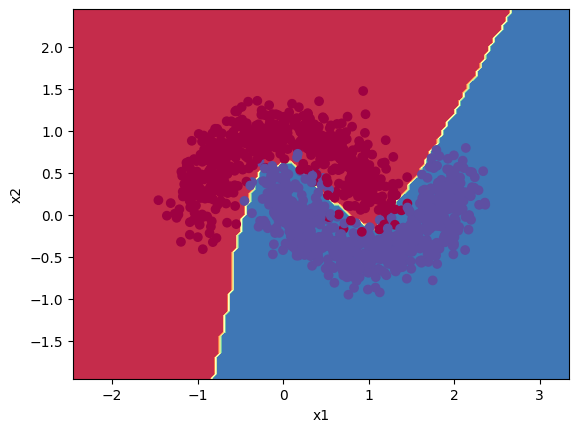

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Saving and Loading Keras Models

You can easily save your entire model (architecture, weights, and optimizer state) in a single call using either `.keras` or `.h5` formats.

- **`.keras`**: The default and recommended format from TensorFlow 2.12 onwards. It includes comprehensive model metadata and is future-proof.
- **`.h5`**: An older HDF5 format that is still widely used due to its simplicity and compatibility.


In [ ]:
import datetime

# Save model with timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name_keras = f"keras_model_{current_time}.keras"
# model_name_h5 = f"keras_model_{current_time}.h5"

# Save in .keras format (recommended for TensorFlow/Keras > 2.12)
model.save(model_name_keras)

# Alternatively, save in .h5 format
# model.save(model_name_h5)

print(f"Models saved as: {model_name_keras}")

Models saved as: keras_model_20250522-163933.keras


In [ ]:
# List files in current directory
!ls -l

total 64
-rw-r--r-- 1 root root 26668 May 22 16:39 keras_model_20250522-163933.keras
-rw-r--r-- 1 root root 30749 May 22 16:06 model.png
drwxr-xr-x 1 root root  4096 May 14 13:38 sample_data


In [ ]:
from tensorflow.keras.models import load_model

# Load your previously saved model
loaded_model = load_model(model_name_keras)  # or .h5

# Evaluate loaded model
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded model accuracy: {accuracy*100:.2f}%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9747 - loss: 0.0678
Loaded model accuracy: 97.76%


### Question 4: Train 10 epochs, save the model, load it, and then train 10 more epochs

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7899 - loss: 0.5430 - val_accuracy: 0.8200 - val_loss: 0.4907
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8063 - loss: 0.4748 - val_accuracy: 0.8347 - val_loss: 0.4315
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8145 - loss: 0.4197 - val_accuracy: 0.8360 - val_loss: 0.3867
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8305 - loss: 0.3758 - val_accuracy: 0.8400 - val_loss: 0.3545
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8467 - loss: 0.3408 - val_accuracy: 0.8467 - val_loss: 0.3304
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8575 - loss: 0.3121 - val_accuracy: 0.8627 - val_loss: 0.3124
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8698 - loss: 0.2901 - val_accuracy: 0.8667 - val_loss: 0.3002
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8803 - loss: 0.2760 - val_accuracy: 0.8693 - val_loss

In [ ]:
# Save model with timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"keras_model_{current_time}.keras"
model.save(model_name)

In [ ]:
# load the model
from tensorflow.keras.models import load_model

# Load your previously saved model
loaded_model = load_model(model_name)


In [ ]:
# Train the model 10 more epochs
model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=64)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8884 - loss: 0.2548 - val_accuracy: 0.8747 - val_loss: 0.2745
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8908 - loss: 0.2492 - val_accuracy: 0.8760 - val_loss: 0.2684
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8952 - loss: 0.2435 - val_accuracy: 0.8827 - val_loss: 0.2620
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8986 - loss: 0.2374 - val_accuracy: 0.8840 - val_loss: 0.2543
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9017 - loss: 0.2307 - val_accuracy: 0.8880 - val_loss: 0.2457
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9051 - loss: 0.2231 - val_accuracy: 0.8973 - val_loss: 0.2365
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9117 - loss: 0.2148 - val_accuracy: 0.9013 - val_loss: 0.2269
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9151 - loss: 0.2062 - val_accuracy: 0.9067 - val_loss:

Test Loss: 0.1429542452096939
Test Accuracy: 0.9440000057220459
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


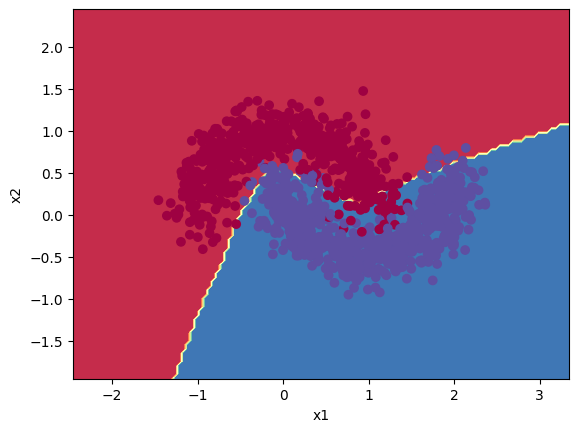

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

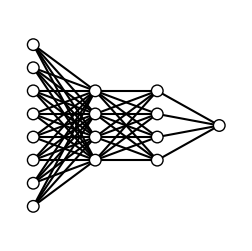

In [ ]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [ ]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, activation="sigmoid", name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

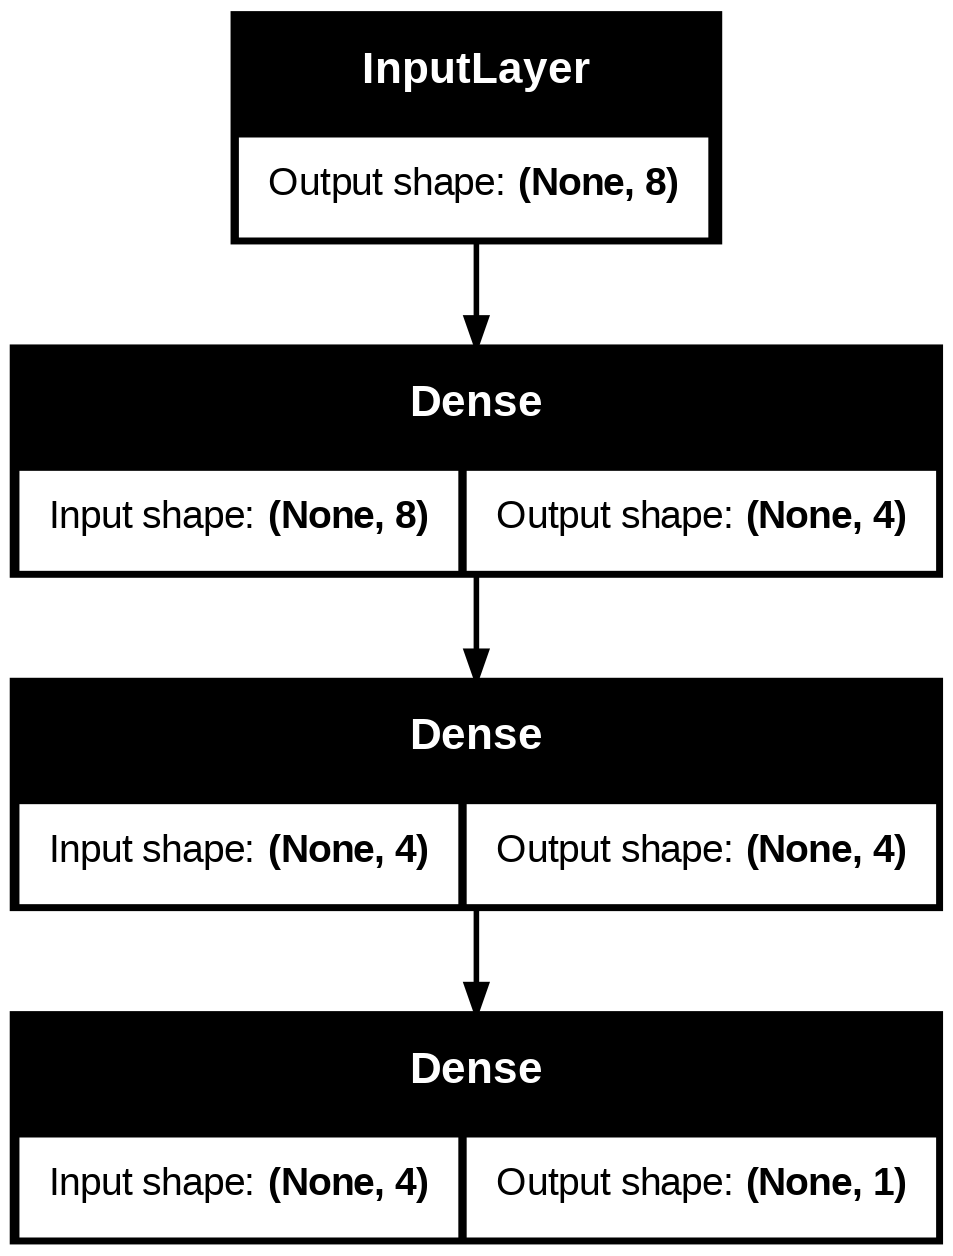

In [ ]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [ ]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

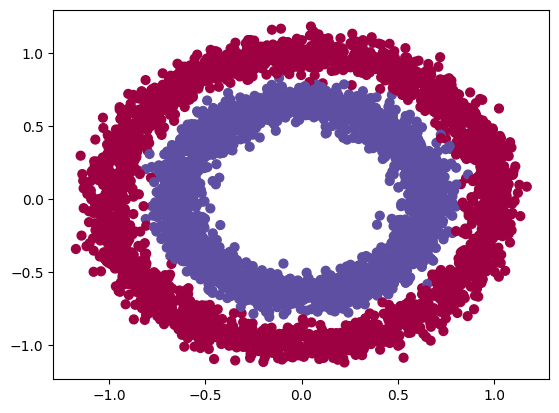

In [ ]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(f'X shape:{X.shape}, y shape:{y.shape}')
print(f'X_train shape:{X_train.shape}, y_train shape:{y_train.shape}')
print(f'X_test shape:{X_test.shape}, y_test shape:{y_test.shape}')

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

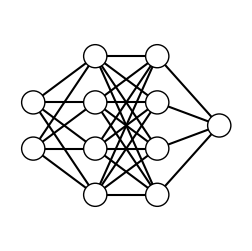

In [ ]:
draw_neural_net(.1, .9, .1, .9, [2, 4, 4, 1])

In [ ]:
# We define a model using Keras Functional API
# Input layer
inputs = keras.Input(shape=(2, ), name='input')

# First hidden layer
layer_1 = layers.Dense(8, activation='relu',
                       name='layer_1')(inputs)
# Second hidden layer
layer_2 = layers.Dense(8, activation='relu',
                       name='layer_2')(layer_1)
# Output layer
outputs = layers.Dense(1, activation='sigmoid', name='output')(layer_2)


model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=53, validation_split=0.2, batch_size=32, verbose=0)

Test Loss: 0.015651630237698555
Test Accuracy: 0.9976000189781189
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


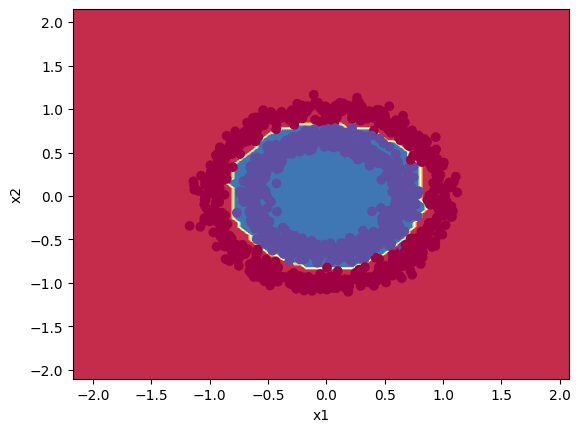

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Visualize decision boundary by epoch

In [ ]:
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import os

In [ ]:
def plot_save_decision_boundary(model, X, y, epoch, epoch_image):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.5, colors=['blue', 'red'], levels=[-0.5, 0.5, 1.5])
    plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
    plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1', alpha=0.5)
    plt.title(f'Epoch {epoch}')
    plt.savefig(epoch_image)
    plt.close()

def generate_spiral_dataset(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise

    X, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))))
    return X, y.reshape(-1, 1)

n_points = 2500
X, y = generate_spiral_dataset(n_points)

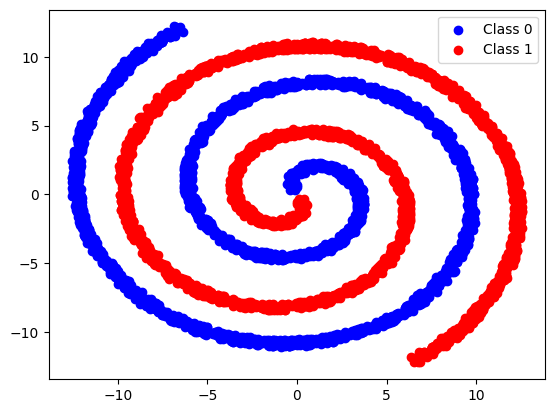

In [ ]:
plt.scatter(X[y[:, 0] == 0][:, 0], X[y[:, 0] == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y[:, 0] == 1][:, 0], X[y[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.legend()
plt.show()

In [ ]:
# Normalize data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = tf.keras.Sequential([
    keras.Input(shape=(2,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

n_epochs = 100
epoch_images = []

for epoch in range(n_epochs):
    model.fit(X_train, y_train, epochs=1, verbose=0)
    epoch_image = f'epoch_{epoch}.png'
    epoch_images.append(epoch_image)

    plot_save_decision_boundary(model, X_test, y_test, epoch, epoch_image)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━

In [ ]:
from PIL import Image as Image_PIL

# Create the GIF
gif_filename = 'epoch_animation.gif'
images = [Image_PIL.open(epoch_image) for epoch_image in epoch_images]

duration = 0.15
images[0].save(gif_filename,
            format='GIF',
            append_images=images[1:],
            save_all=True,
            duration=duration*1000,
            loop=0)

# Delete the individual epoch images
for epoch_image in epoch_images:
    os.remove(epoch_image)

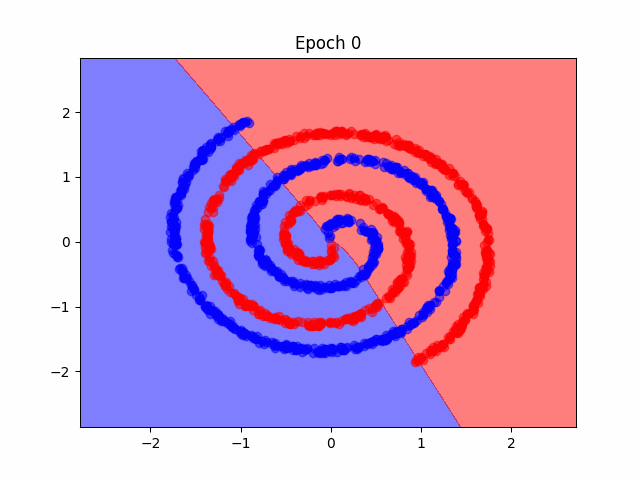

In [ ]:
# Display the GIF
Image(filename=gif_filename)